# Laboratorio de predicción lineal

## Intentaremos aplicar predicción lineal sobre señales de voz.

In [97]:
%pip install wget

In [98]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import wget
import scipy.io.wavfile as wave
import IPython
from scipy.linalg import toeplitz, inv
from scipy.fftpack import fft

## Sabiendo que las señales de voz pueden ser modeladas con un modelo autorregresivo:

### 1. Realizar una grabación de duración T = 2 s y fs = 8 kHz de los sonidos /a/ y /sh/.

In [99]:
a_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/a.wav'
a_file = wget.download(a_url)

sh_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/sh.wav'
sh_file = wget.download(sh_url)

In [100]:
fs, a_arr = wave.read(a_file)
# Downsample fs to 8KHz
desired_fs = 8000
final_len = int(len(a_arr) * (8000/fs))
resampled_a = sig.resample(a_arr, final_len)
norm_a = resampled_a/np.amax(abs(resampled_a))

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_a)))
IPython.display.Audio(resampled_a,rate=desired_fs)

fs = 8000
Number of samples = 20640


In [101]:
fs, sh_arr = wave.read(str(sh_file))

# Downsample fs to 8KHz
desired_fs = 8000
final_len = int(len(sh_arr) * (8000/fs))
resampled_sh = sig.resample(sh_arr, final_len)
norm_sh = resampled_sh/np.amax(abs(resampled_sh))

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_sh)))
IPython.display.Audio(resampled_sh,rate=desired_fs)

fs = 8000
Number of samples = 19616


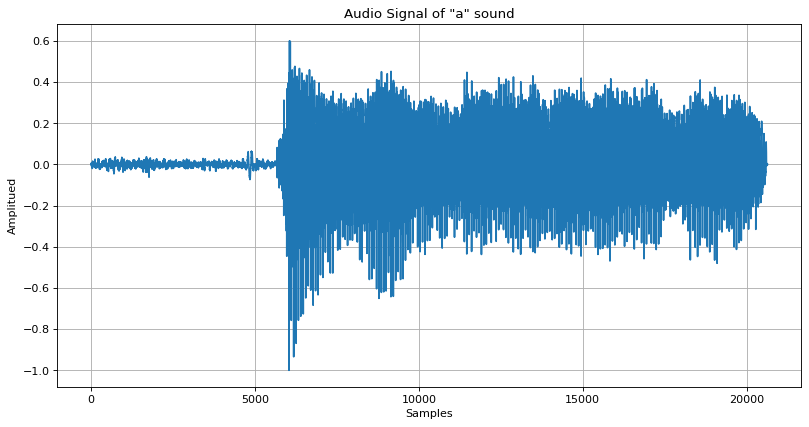

In [102]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitued')
plt.xlabel('Samples')
plt.title('Audio Signal of "a" sound')
plt.grid('on')
plt.plot(norm_a)
plt.show()

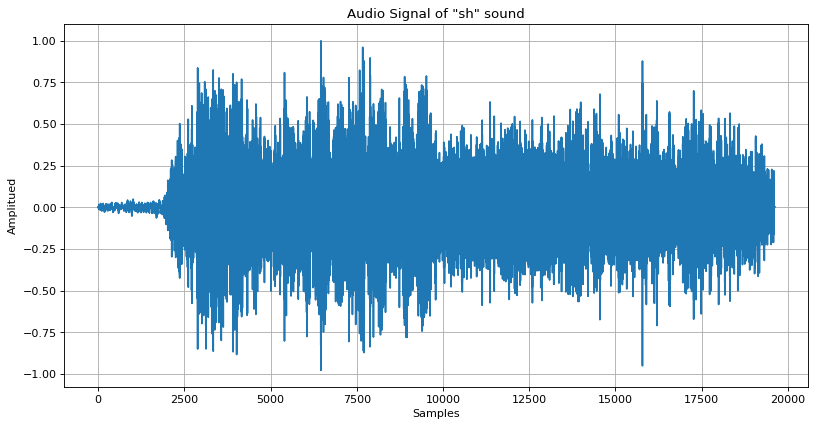

In [103]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitued')
plt.xlabel('Samples')
plt.title('Audio Signal of "sh" sound')
plt.grid('on')
plt.plot(norm_sh)
plt.show()

### 2. Para ambos sonidos, realizar la predicción forward con $ N_{o} = 1 $, y representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.

In [104]:
def autocorreltion(x):
  norm_x = (x - x.mean())/(abs(x).max())
  return np.correlate(norm_x,norm_x,mode='full') / len(x)

def LevinsonDurbin(r,debug = False):
  last_delta = np.conj(r[1])
  a_coefs = 1
  M = len(r)-1
  P_values = []
  P_values.append(r[0])
  for i in range(1,M+1):
    k = (-last_delta) / P_values[-1]
    last_coefs = a_coefs
    a_coefs = np.ones(i+1, dtype= np.float64)
    a_coefs[-1] = k 
    if (i>1):
      a_coefs[1:-1] = last_coefs[1:] + k*np.flip(np.conj(last_coefs[1:]))
    P_values.append( P_values[-1] * (1- (abs(k)**2) ) )
    if (i < M):
      last_delta = np.dot(np.flip(r[1:i+2]),a_coefs)
    if debug:
      print("m = "+str(i))
      print("a_coefs:",a_coefs)
      print("p = "+str(P_values[-1]))
      print("k = "+str(k))
      print("delta = ")
      print(last_delta)
  return a_coefs,P_values

In [105]:
def a_sub_k_to_w_sub_k(a_arr):
    return (-np.asarray(a_arr[1:]))

In [106]:
def plot_m_vs_j(ms, js):
    plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.ylabel('Pm')
    plt.xlabel('M')
    plt.title('J(M)')
    plt.grid('on')
    plt.xticks(np.arange(1, len(ms), step=4))
    plt.plot(ms, js)
    plt.show()

# Codigo copiado de https://pyspectrum.readthedocs.io/en/latest/_modules/spectrum/levinson.html para contrastar

In [107]:
import numpy


__all__ = ["LEVINSON", "rlevinson"]

def LEVINSON(r, order=None, allow_singularity=False):
    #from numpy import isrealobj
    T0  = numpy.real(r[0])
    T = r[1:]
    M = len(T)

    if order is None:
        M = len(T)
    else:
        assert order <= M, 'order must be less than size of the input data'
        M = order

    realdata = numpy.isrealobj(r)
    if realdata is True:
        A = numpy.zeros(M, dtype=float)
        ref = numpy.zeros(M, dtype=float)
    else:
        A = numpy.zeros(M, dtype=complex)
        ref = numpy.zeros(M, dtype=complex)

    P = T0

    for k in range(0, M):
        save = T[k]
        if k == 0:
            temp = -save / P
        else:
            #save += sum([A[j]*T[k-j-1] for j in range(0,k)])
            for j in range(0, k):
                save = save + A[j] * T[k-j-1]
            temp = -save / P
        if realdata:
            P = P * (1. - temp**2.)
        else:
            P = P * (1. - (temp.real**2+temp.imag**2))
        if P <= 0 and allow_singularity==False:
            raise ValueError("singular matrix")
        A[k] = temp
        ref[k] = temp # save reflection coeff at each step
        if k == 0:
            continue

        khalf = (k+1)//2
        if realdata is True:
            for j in range(0, khalf):
                kj = k-j-1
                save = A[j]
                A[j] = save + temp * A[kj]
                if j != kj:
                    A[kj] += temp*save
        else:
            for j in range(0, khalf):
                kj = k-j-1
                save = A[j]
                A[j] = save + temp * A[kj].conjugate()
                if j != kj:
                    A[kj] = A[kj] + temp * save.conjugate()

    return A, P, ref



def rlevinson(a, efinal):
    """computes the autocorrelation coefficients, R based
    on the prediction polynomial A and the final prediction error Efinal,
    using the stepdown algorithm.

    Works for real or complex data

    :param a:
    :param efinal:

    :return:
        * R, the autocorrelation
        * U  prediction coefficient
        * kr reflection coefficients
        * e errors

    A should be a minimum phase polynomial and A(1) is assumed to be unity.

    :returns: (P+1) by (P+1) upper triangular matrix, U,
        that holds the i'th order prediction polynomials
        Ai, i=1:P, where P is the order of the input
        polynomial, A.



             [ 1  a1(1)*  a2(2)* ..... aP(P)  * ]
             [ 0  1       a2(1)* ..... aP(P-1)* ]
       U  =  [ .................................]
             [ 0  0       0      ..... 1        ]

    from which the i'th order prediction polynomial can be extracted
    using Ai=U(i+1:-1:1,i+1)'. The first row of U contains the
    conjugates of the reflection coefficients, and the K's may be
    extracted using, K=conj(U(1,2:end)).

    .. todo:: remove the conjugate when data is real data, clean up the code
       test and doc.

    """
    a = numpy.array(a)
    realdata = numpy.isrealobj(a)


    assert a[0] == 1, 'First coefficient of the prediction polynomial must be unity'

    p = len(a)

    if p < 2:
        raise ValueError('Polynomial should have at least two coefficients')

    if realdata == True:
        U = numpy.zeros((p, p)) # This matrix will have the prediction
                                # polynomials of orders 1:p
    else:
        U = numpy.zeros((p, p), dtype=complex)
    U[:, p-1] = numpy.conj(a[-1::-1]) # Prediction coefficients of order p

    p = p -1
    e = numpy.zeros(p)

    # First we find the prediction coefficients of smaller orders and form the
    # Matrix U

    # Initialize the step down

    e[-1] = efinal # Prediction error of order p

    # Step down
    for k in range(p-1, 0, -1):
        [a, e[k-1]] = levdown(a, e[k])
        U[:, k] = numpy.concatenate((numpy.conj(a[-1::-1].transpose()) ,
                                      [0]*(p-k) ))




    e0 = e[0]/(1.-abs(a[1]**2)) #% Because a[1]=1 (true polynomial)
    U[0,0] = 1                #% Prediction coefficient of zeroth order
    kr = numpy.conj(U[0,1:])     #% The reflection coefficients
    kr = kr.transpose()                 #% To make it into a column vector

    #   % Once we have the matrix U and the prediction error at various orders, we can
    #  % use this information to find the autocorrelation coefficients.

    R = numpy.zeros(1, dtype=complex)
    #% Initialize recursion
    k = 1
    R0 = e0 # To take care of the zero indexing problem
    R[0] = -numpy.conj(U[0,1])*R0   # R[1]=-a1[1]*R[0]

    # Actual recursion
    for k in range(1,p):
        r = -sum(numpy.conj(U[k-1::-1,k])*R[-1::-1]) - kr[k]*e[k-1]
        R = numpy.insert(R, len(R), r)

    # Include R(0) and make it a column vector. Note the dot transpose

    #R = [R0 R].';
    R = numpy.insert(R, 0, e0)
    return R, U, kr, e



def levdown(anxt, enxt=None):
    """One step backward Levinson recursion

    :param anxt:
    :param enxt:
    :return:
        * acur the P'th order prediction polynomial based on the P+1'th order prediction polynomial, anxt.
        * ecur the the P'th order prediction error  based on the P+1'th order prediction error, enxt.

    ..  * knxt the P+1'th order reflection coefficient.

    """
    #% Some preliminaries first
    #if nargout>=2 & nargin<2
    #    raise ValueError('Insufficient number of input arguments');
    if anxt[0] != 1:
        raise ValueError('At least one of the reflection coefficients is equal to one.')
    anxt = anxt[1:] #  Drop the leading 1, it is not needed
                    #  in the step down

    # Extract the k+1'th reflection coefficient
    knxt = anxt[-1]
    if knxt == 1.0:
        raise ValueError('At least one of the reflection coefficients is equal to one.')

    # A Matrix formulation from Stoica is used to avoid looping
    acur = (anxt[0:-1]-knxt*numpy.conj(anxt[-2::-1]))/(1.-abs(knxt)**2)
    ecur = None
    if enxt is not None:
        ecur = enxt/(1.-numpy.dot(knxt.conj().transpose(),knxt))

    acur = numpy.insert(acur, 0, 1)

    return acur, ecur


def levup(acur, knxt, ecur=None):
    """LEVUP  One step forward Levinson recursion

    :param acur:
    :param knxt:
    :return:
        * anxt the P+1'th order prediction polynomial based on the P'th order prediction polynomial, acur, and the
          P+1'th order reflection coefficient, Knxt.
        * enxt the P+1'th order prediction  prediction error, based on the P'th order prediction error, ecur.


    :References:  P. Stoica R. Moses, Introduction to Spectral Analysis  Prentice Hall, N.J., 1997, Chapter 3.
    """
    if acur[0] != 1:
        raise ValueError('At least one of the reflection coefficients is equal to one.')
    acur = acur[1:] #  Drop the leading 1, it is not needed

    # Matrix formulation from Stoica is used to avoid looping
    anxt = numpy.concatenate((acur, [0])) + knxt * numpy.concatenate((numpy.conj(acur[-1::-1]), [1]))

    enxt = None
    if ecur is not None:
        # matlab version enxt = (1-knxt'.*knxt)*ecur
        enxt = (1. - numpy.dot(numpy.conj(knxt), knxt)) * ecur

    anxt = numpy.insert(anxt, 0, 1)

    return anxt, enxt

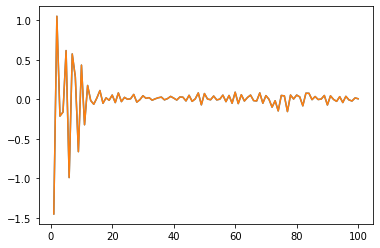

100
101
0.0007026114251922246


In [108]:
# Levinson Durbin Test
M = 100
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+M+1]

a1, p1, ref1 = LEVINSON(r)
a2, p2 = LevinsonDurbin(r)

k = range(1,M+1,1)
plt.plot(k,a1)
plt.plot(k,a2[1:])
plt.show()
print(len(a1))
print(len(a2))
print(p2[-1])

### Forward prediction of 'a' signal with $ N_{o} = 1 $:

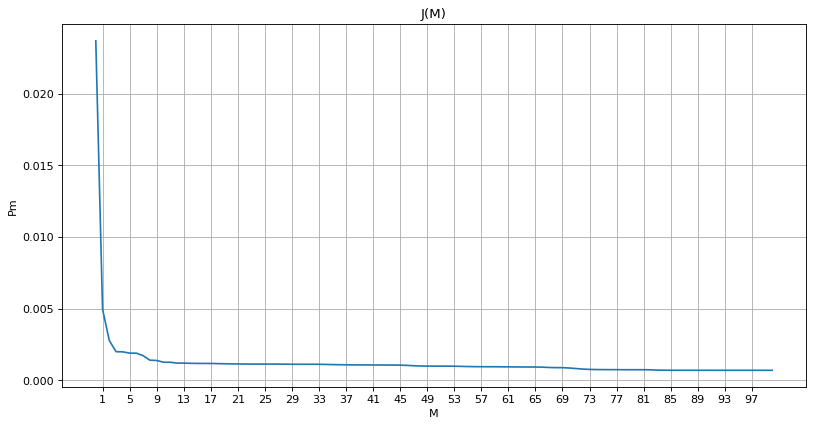

In [110]:
# Representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.
i = 101
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+i]
M = len(r)-1
m = np.arange(0,M+1)
_, p_list = LevinsonDurbin(r)
plot_m_vs_j(m, p_list)

### Forward prediction of 'sh' signal with $ N_{o} = 1 $:

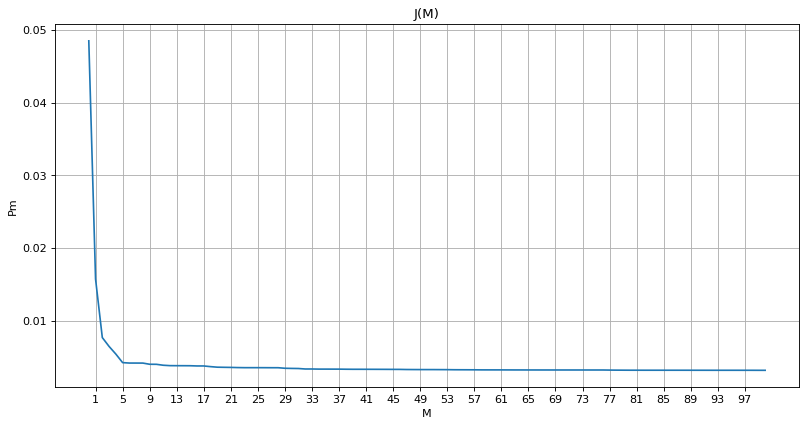

In [113]:
# Representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.
i = 101
r = autocorreltion(resampled_sh)
r = r[r.argmax():r.argmax()+i]
M = len(r)-1
m = np.arange(0,M+1)
_, p_list = LevinsonDurbin(r)
plot_m_vs_j(m, p_list)

### 3. Para ambos sonidos, analizar cualitativa y cuantitativamente la señal del error de predicción y el espectro $ H(e^{jω}) $ del filtro autorregresivo estimado para M = 1, 6, 12, 24, 100. Comparar este espectro con el espectro obtenido por estimación no-paramétrica.

In [114]:
def filterW(data, w_o):
    samples = len(data)
    filtered = np.zeros(samples)
    filtered = sig.filtfilt(w_o, [1], data)
    return filtered

In [115]:
def plot_fm_fft(fs, data, m):
    N = len(data)
    fft_res = fft(x=data, n=N)
    Spd = np.power(np.abs(fft_res), 2)
    Spd /= sum(Spd)
    freqs = np.linspace(0, fs/2, N//2)
    plt.semilogx(freqs, 2/N * np.abs(Spd[:N//2]), label='M = '+str(M))

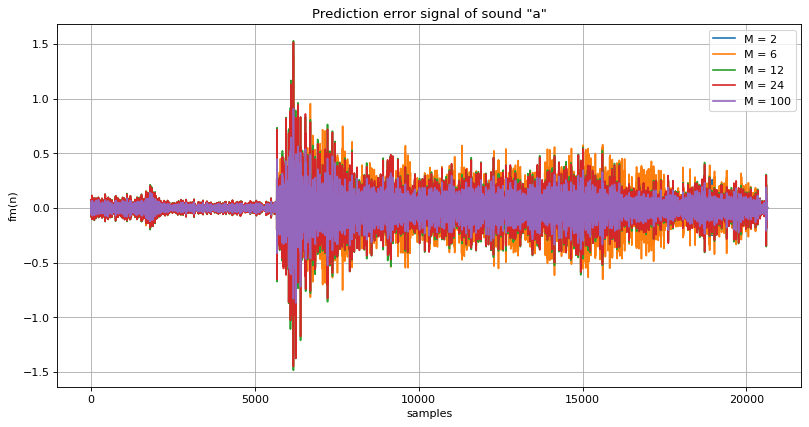

In [124]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('fm(n)')
plt.xlabel('samples')
plt.title('Prediction error signal of sound "a"')
plt.grid('on')

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_a)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_a, a_coefs)
    plt.plot(fm, label='M = '+str(M))
    #plt.plot(a_coefs, label='M = '+str(M))
plt.legend()
plt.show()

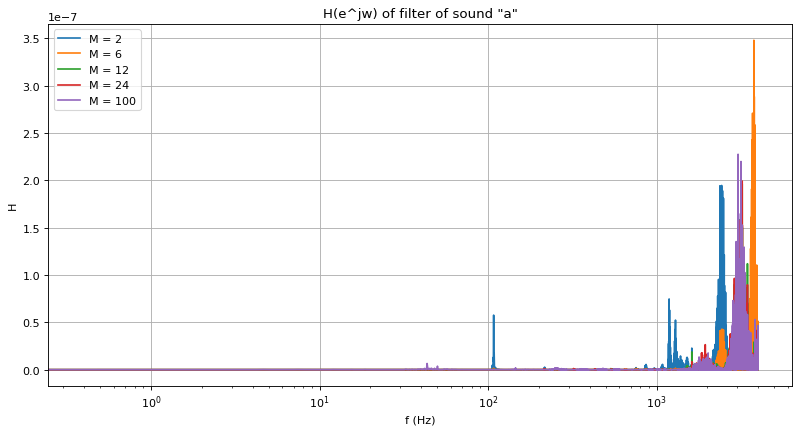

In [125]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('H')
plt.xlabel('f (Hz)')
plt.title('H(e^jw) of filter of sound "a"')
plt.grid('on')

fs = 8000

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_a)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_a, a_coefs)
    plot_fm_fft(fs, fm, M)
plt.legend()
plt.show()

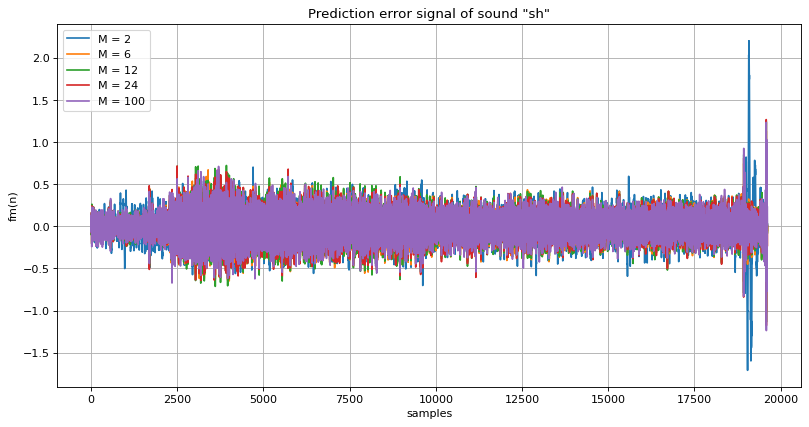

In [126]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('fm(n)')
plt.xlabel('samples')
plt.title('Prediction error signal of sound "sh"')
plt.grid('on')

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_sh)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_sh, a_coefs)
    plt.plot(fm, label='M = '+str(M))
plt.legend()
plt.show()

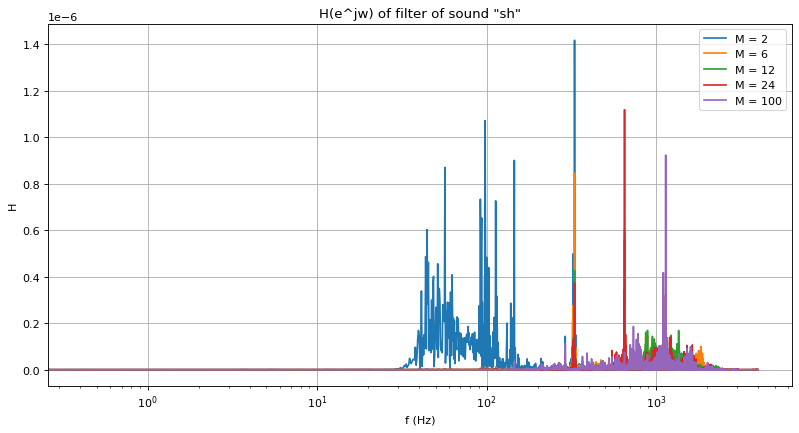

In [119]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('H')
plt.xlabel('f (Hz)')
plt.title('H(e^jw) of filter of sound "sh"')
plt.grid('on')

fs = 8000

for M in (2, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_sh)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_sh, a_coefs)
    plot_fm_fft(fs, fm, M)
plt.legend()
plt.show()

### 4. ¿Cuál es el orden óptimo Mo para cada sonido?

In [120]:
Mopt = 12

### 5. Sintetizar los sonidos aplicando el filtro autorregresivo estimado de orden Mo a una excitación apropiada.

In [121]:
def get_ak_wk_pm(data, M):
    i = M+1
    r = autocorreltion(data)
    r = r[r.argmax():r.argmax()+i]
    ak, p_list = LevinsonDurbin(r)
    wk = a_sub_k_to_w_sub_k(ak)
    return ak, wk, p_list[-1]

In [122]:
def synth(v_n, wk):
    y_synth = np.zeros(len(v_n) + len(wk)) #Concateno M ceros de mas al principio
    for k in range(len(wk), len(y_synth)):
        y_aux = 0
        for i in range(1,len(wk)+1):
            #print(y_synth[k-i])
            #print(wk[i-1])
            y_aux = y_aux + y_synth[k-i]*wk[i-1]      
        y_synth[k] = y_aux + v_n[k-len(wk)]
    return y_synth[len(wk):]

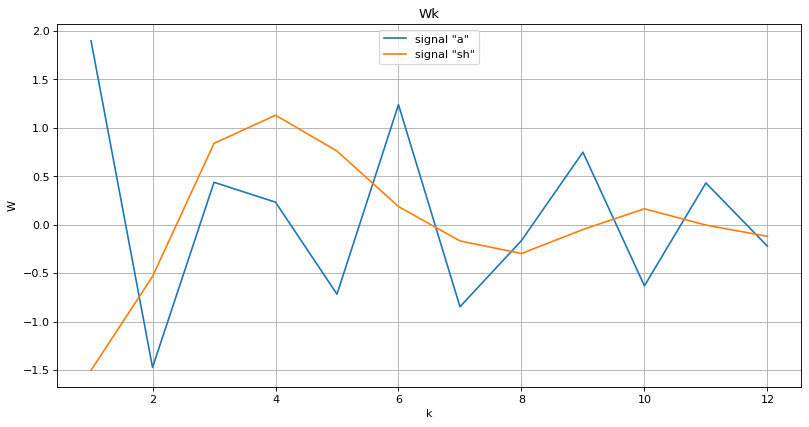

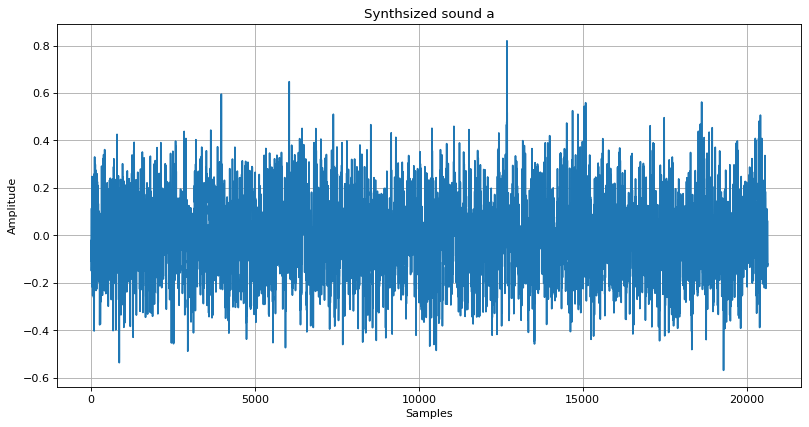

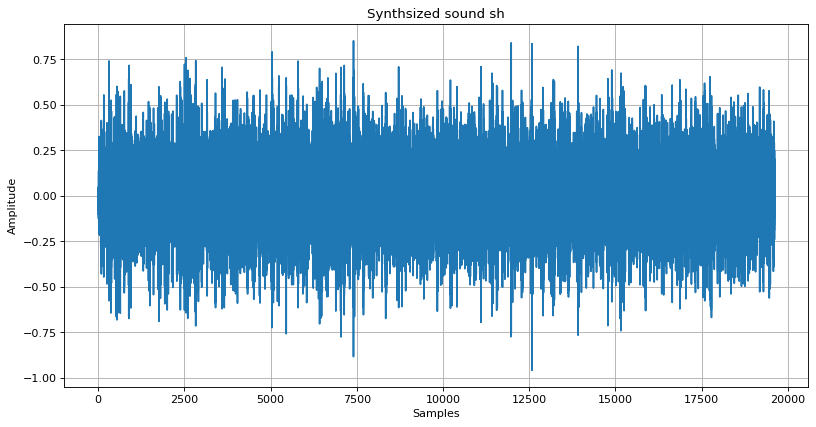

In [127]:
N_a = len(norm_a)
ak_a, wk_a, p_a = get_ak_wk_pm(norm_a, Mopt)
noise_a = np.random.normal(0, np.sqrt(p_a), N_a)

N_sh = len(norm_sh)
ak_sh, wk_sh, p_sh = get_ak_wk_pm(norm_sh, Mopt)
noise_sh = np.random.normal(0,np.sqrt(p_sh), N_sh)

synth_a = synth(noise_a, wk_a)
synth_sh = synth(noise_sh, wk_sh)

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('W')
plt.xlabel('k')
plt.title('Wk')
plt.grid('on')
plt.plot(np.arange(1,Mopt+1), wk_a, label='signal "a"')
plt.plot(np.arange(1,Mopt+1), wk_sh, label='signal "sh"')
plt.legend(loc='upper center')
plt.show()

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Synthsized sound a')
plt.grid('on')
plt.plot(synth_a)
plt.show()

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Synthsized sound sh')
plt.grid('on')
plt.plot(synth_sh)
plt.show()

In [128]:
IPython.display.Audio(noise_a,rate=desired_fs)

In [129]:
IPython.display.Audio(synth_sh,rate=desired_fs)

In [130]:
IPython.display.Audio(synth_a,rate=desired_fs)

### 6. Para el sonido /a/ y con Mo, realizar la recursión de Levinson-Durbin y representar los coeficientes κm en función de m.

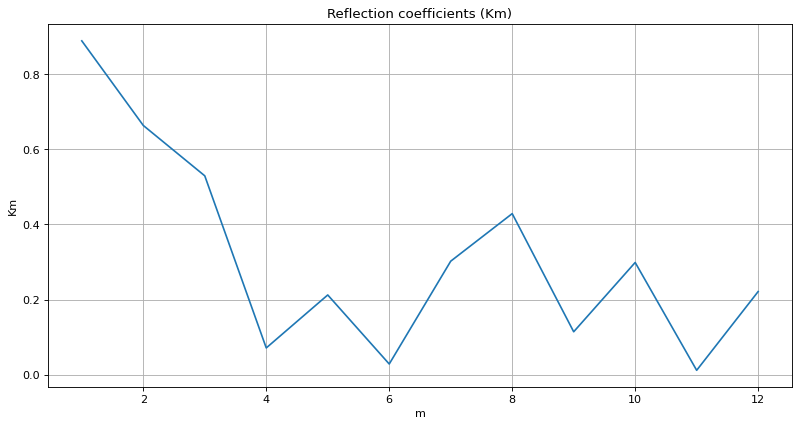

In [131]:
i = Mopt+1
r = autocorreltion(norm_a)
r = r[r.argmax():r.argmax()+i]
_, p_list = LevinsonDurbin(r)
ks = list()

for m in range(1, len(p_list)):
    k_aux = np.sqrt(1-(p_list[m]/p_list[m-1]))
    ks.append(k_aux)


plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Km')
plt.xlabel('m')
plt.title('Reflection coefficients (Km)')
plt.grid('on')
plt.plot(np.arange(1,len(p_list)), ks)
plt.show()